<a href="https://colab.research.google.com/github/specM7/DSGP_Group_33_Brain_Tumor_Predictor/blob/Pituitary-Adenomas-Malindu-2425440/Pituitary_Adenomas_Malindu_2425440.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Directories for training and testing data
# train_dir = '/content/drive/MyDrive/Training'
train_dir = '/content/drive/MyDrive/new'

# Define image size for VGG16
IMAGE_SIZE = 224


# # Load and shuffle the train data
# train_paths = []
# train_labels = []
# train_paths = []
# train_labels = []

# for label in os.listdir(train_dir):
#     label_path = os.path.join(train_dir, label)

#     # # Skip if this entry is not a directory
#     # if os.path.isdir(label_path)== False:
#     #     continue
#     train_paths.append(label_path)
#     train_labels.append(label_path)
train_paths = []
train_labels = []

for fname in os.listdir(train_dir):
    fname_lower = fname.lower()

    if not fname_lower.endswith(('.jpg', '.jpeg', '.png')):
        continue

    if 'tr-pi_' in fname_lower:
        label = 'pi'
    elif 'tr-no_' in fname_lower:
        label = 'no'
    else:
        continue  # skip unknown files

    train_paths.append(os.path.join(train_dir, fname))
    train_labels.append(label)
from sklearn.model_selection import train_test_split

X_paths_train, X_paths_test, y_train, y_test = train_test_split(
    train_paths,
    train_labels,
    test_size=0.25,
    stratify=train_labels,   # ensures mix of pi & no
    random_state=42
)

print(f"Loaded {len(train_paths)} images")
print("Class distribution:")
from collections import Counter
print(Counter(train_labels))


Loaded 117 images
Class distribution:
Counter({'pi': 67, 'no': 50})


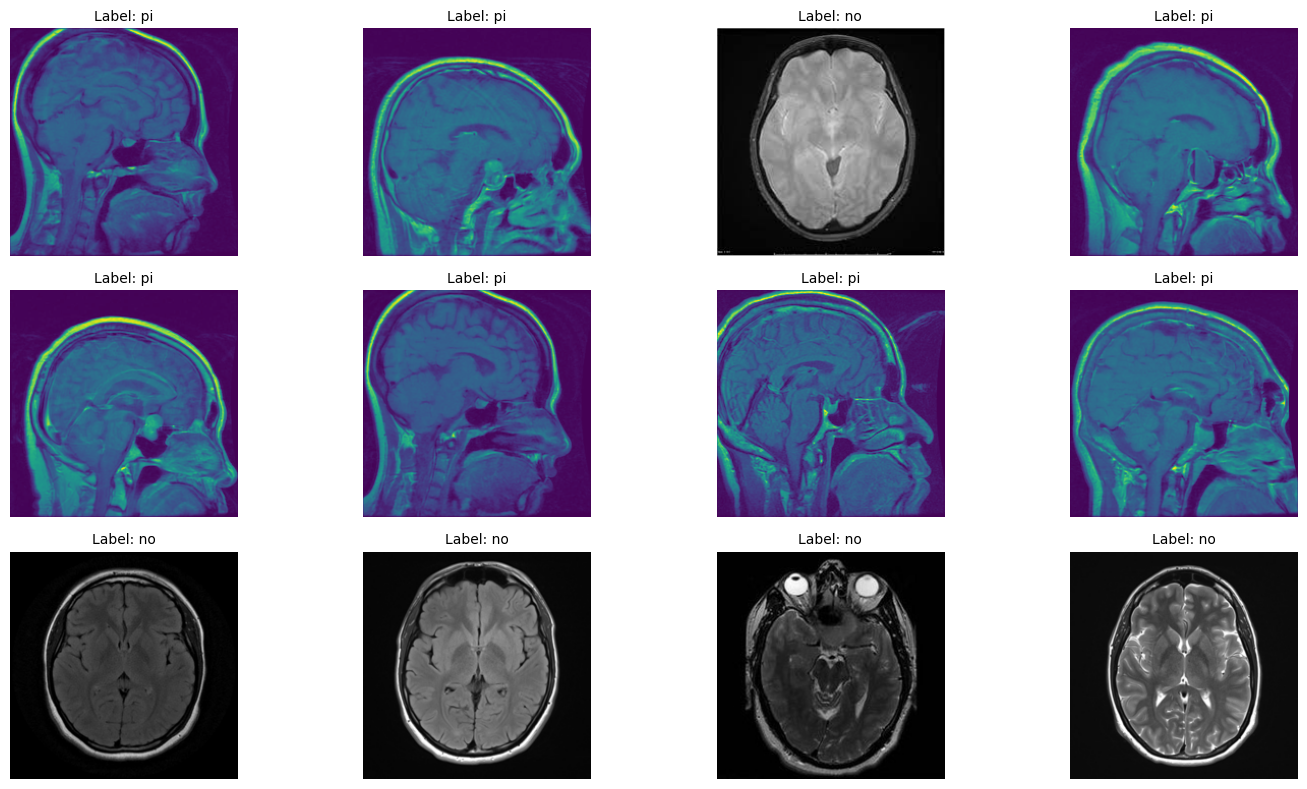

In [48]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
# random_indices = random.sample(range(len(train_paths)), 12)
num_images_to_show = min(12, len(train_paths))
random_indices = random.sample(range(len(train_paths)), num_images_to_show)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.ravel()

for i_display, idx_original in enumerate(random_indices):
    # Load image using the original index from train_paths
    img_path = train_paths[idx_original]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image on the i_display-th axis
    axes[i_display].imshow(img)
    axes[i_display].axis('off')  # Hide axis
    # Display class label
    axes[i_display].set_title(f"Label: {train_labels[idx_original]}", fontsize=10)

plt.tight_layout()
plt.show()

In [49]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    IMAGE_SIZE = 224

    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)
        image = augment_image(image)
        images.append(image)

    return np.array(images)


# Encoding labels (convert label names to integers)
def encode_label(labels):
    label_map = {'no': 0, 'pi': 1}
    return np.array([label_map[label] for label in labels])


# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [50]:
# Load VGG16 model without top layers for feature extraction
def create_vgg16_feature_extractor():
    IMAGE_SIZE = 224
    vgg_base = VGG16(weights='imagenet',
                     include_top=False,
                     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Freeze all layers
    for layer in vgg_base.layers:
        layer.trainable = False

    return vgg_base

# Feature extraction function
def extract_features(paths, labels, vgg_model, batch_size=32):
    all_features = []
    all_encoded_labels = []

    # Encode all labels first
    encoded_labels = encode_label(labels)

    # Process in batches to avoid memory issues
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i + batch_size]
        batch_labels = encoded_labels[i:i + batch_size]

        # Load and preprocess images
        batch_images = open_images(batch_paths)

        # Extract features using VGG16
        features = vgg_model.predict(batch_images, verbose=0)
        features_flat = features.reshape(features.shape[0], -1)

        all_features.append(features_flat)
        all_encoded_labels.extend(batch_labels)

    # Combine all features
    all_features = np.vstack(all_features)
    all_encoded_labels = np.array(all_encoded_labels)
    print(f"All features shape: {all_features.shape}")
    print(all_encoded_labels)
    return all_features, all_encoded_labels

In [51]:
# Create and train the hybrid model
def create_hybrid_model():
    # Create VGG16 feature extractor
    vgg_model = create_vgg16_feature_extractor()

    # Extract features from training and testing data


    X_train_feat, y_train_enc = extract_features(
        X_paths_train, y_train, vgg_model
    )

    X_test_feat, y_test_enc = extract_features(
        X_paths_test, y_test, vgg_model
    )

    print(f"Training features shape: {X_train_feat.shape}")
    print(f"Training labels shape: {y_train_enc.shape}")

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    epochs = [10, 30, 60, 100, 150]
    train_acc = []
    test_acc = []
    models = []

    for n_trees in epochs:
        rf = RandomForestClassifier(
            n_estimators=n_trees,
            max_depth=20,
            random_state=42,
            n_jobs=-1
        )

        rf.fit(X_train_feat, y_train_enc)

        train_pred = rf.predict(X_train_feat)
        test_pred = rf.predict(X_test_feat)

        train_acc.append(accuracy_score(y_train_enc, train_pred))
        test_acc.append(accuracy_score(y_test_enc, test_pred))

        models.append(rf)

        print(f"Trees: {n_trees}")
        print(f"  Train acc: {train_acc[-1]:.4f}")
        print(f"  Test acc : {test_acc[-1]:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
    plt.plot(epochs, test_acc, marker='o', label='Testing Accuracy')
    plt.xlabel("Number of Trees (Epoch Proxy)")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve: VGG16 + Random Forest")
    plt.legend()
    plt.grid(True)
    plt.show()


    print("\nSample predictions:\n")

    label_map = {0: "no", 1: "pi"}

    for i in range(min(15, len(X_paths_test))):
        pred_label = label_map[test_pred[i]]
        true_label = y_test[i]

        print(
            f"Image: {os.path.basename(X_paths_test[i])} | "
            f"Predicted: {pred_label} | Actual: {true_label}"
        )


    return vgg_model, rf_classifier

# ====Using VGG and sequential models : 1st prototype====
#     # Model architecture
# IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
# base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# # Freeze all layers of the VGG16 base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Set the last few layers of the VGG16 base model to be trainable
# base_model.layers[-2].trainable = True
# base_model.layers[-3].trainable = True
# base_model.layers[-4].trainable = True

# # Build the final model
# model = Sequential()
# model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
# model.add(base_model)  # Add VGG16 base model
# model.add(Flatten())  # Flatten the output of the base model
# model.add(Dropout(0.3))  # Dropout layer for regularization
# model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
# model.add(Dropout(0.2))  # Dropout layer for regularization
# model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='sparse_categorical_crossentropy',
#               metrics=['sparse_categorical_accuracy'])

# # Parameters
# batch_size = 20
# steps = int(len(train_paths) / batch_size)  # Steps per epoch
# epochs = 5

# # Train the model
# history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
#                     epochs=epochs, steps_per_epoch=steps)

In [52]:
# Function to make predictions
def predict_images(paths, vgg_model, rf_classifier, batch_size=32):
    all_predictions = []
    all_probabilities = []

    # Get unique labels for decoding
    unique_labels = os.listdir(train_dir)

    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i + batch_size]

        # Load and preprocess images
        batch_images = open_images(batch_paths)

        # Extract features using VGG16
        features = vgg_model.predict(batch_images, verbose=0)
        features_flat = features.reshape(features.shape[0], -1)

        # Make predictions
        batch_predictions = rf_classifier.predict(features_flat)
        batch_probabilities = rf_classifier.predict_proba(features_flat)

        # Decode predictions back to label names
        decoded_predictions = [unique_labels[pred] for pred in batch_predictions]

        all_predictions.extend(decoded_predictions)
        all_probabilities.append(batch_probabilities)

    all_probabilities = np.vstack(all_probabilities)
    return all_predictions, all_probabilities


In [53]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def compute_training_accuracy(vgg_model, rf_classifier, paths, labels):
    features, encoded_labels = extract_features(paths, labels, vgg_model)
    predictions = rf_classifier.predict(features)
    accuracy = accuracy_score(encoded_labels, predictions)
    return accuracy


In [54]:
def plot_training_accuracy(accuracy):
    plt.figure(figsize=(6, 4))
    plt.plot([1], [accuracy], marker='o')
    plt.ylim(0, 1)
    plt.xticks([1], ['Training'])
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy of Hybrid VGG16 + Random Forest Model')
    plt.grid(True)
    plt.show()


In [55]:
import joblib

def save_model(vgg_model, rf_classifier, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # Save Random Forest
    joblib.dump(rf_classifier, os.path.join(save_dir, "rf_classifier.pkl"))

    # Save VGG16
    vgg_model.save(os.path.join(save_dir, "vgg16_feature_extractor.keras"))

    print("Models saved successfully.")


In [56]:
from tensorflow.keras.models import load_model

def load_saved_model(save_dir):
    rf_classifier = joblib.load(os.path.join(save_dir, "rf_classifier.pkl"))
    vgg_model = load_model(os.path.join(save_dir, "vgg16_feature_extractor.keras"))
    print("Models loaded successfully.")
    return vgg_model, rf_classifier


All features shape: (87, 25088)
[1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1
 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0
 1 0 1 0 1 0 0 0 1 1 0 0 1]
All features shape: (30, 25088)
[1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0]
Training features shape: (87, 25088)
Training labels shape: (87,)
Trees: 10
  Train acc: 1.0000
  Test acc : 0.9667
Trees: 30
  Train acc: 1.0000
  Test acc : 0.9667
Trees: 60
  Train acc: 1.0000
  Test acc : 0.9667
Trees: 100
  Train acc: 1.0000
  Test acc : 0.9667
Trees: 150
  Train acc: 1.0000
  Test acc : 0.9667


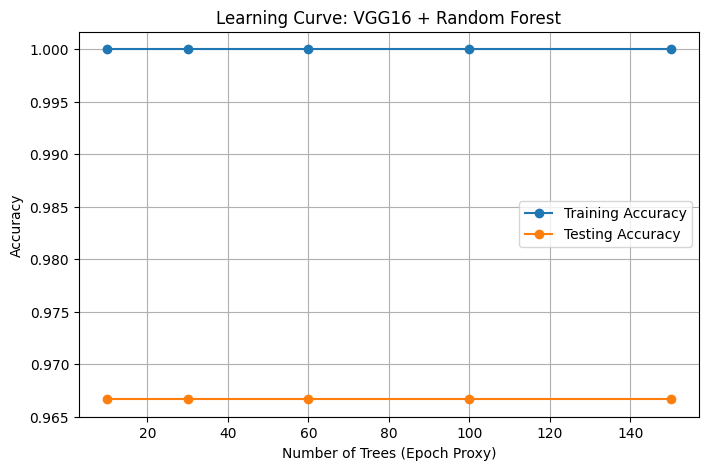


Sample predictions:

Image: Tr-pi_1419.jpg | Predicted: pi | Actual: pi
Image: Tr-no_0026.jpg | Predicted: no | Actual: no
Image: Tr-pi_1400.jpg | Predicted: pi | Actual: pi
Image: Tr-no_0038.jpg | Predicted: no | Actual: no
Image: Tr-pi_1410.jpg | Predicted: pi | Actual: pi
Image: Tr-no_0019.jpg | Predicted: no | Actual: no
Image: Tr-pi_1414.jpg | Predicted: pi | Actual: pi
Image: Tr-pi_1404.jpg | Predicted: pi | Actual: pi
Image: Tr-no_0012.jpg | Predicted: no | Actual: no
Image: Tr-pi_1422.jpg | Predicted: pi | Actual: pi
Image: Tr-no_0016.jpg | Predicted: no | Actual: no
Image: Tr-no_0011.jpg | Predicted: no | Actual: no
Image: Tr-no_0022.jpg | Predicted: pi | Actual: no
Image: Tr-no_0042.jpg | Predicted: no | Actual: no
Image: Tr-no_0054.jpg | Predicted: no | Actual: no


NameError: name 'rf_classifier' is not defined

In [57]:
# STEP 1: Create and train the hybrid model
vgg_model, rf_classifier = create_hybrid_model()





In [ ]:
# STEP 4: Save model to Google Drive
MODEL_SAVE_PATH = "/content/drive/MyDrive/hybrid_vgg_rf_model"

save_model(vgg_model, rf_classifier, MODEL_SAVE_PATH)

# STEP 5: Load saved model
vgg_model_loaded, rf_classifier_loaded = load_saved_model(MODEL_SAVE_PATH)


In [ ]:
# UPLOAD IMAGE & PREDICT


from google.colab import files
import os
from PIL import Image
import matplotlib.pyplot as plt

#  Upload image (any name, any type)
uploaded = files.upload()

# Get uploaded image path
image_path = list(uploaded.keys())[0]

print(f"Uploaded image: {image_path}")

#  Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

#  Load the trained model
vgg_model, rf_classifier = load_saved_model(MODEL_SAVE_PATH)

#  Run prediction using EXISTING pipeline
predictions, probabilities = predict_images(
    paths=[image_path],      # wrap single image as list
    vgg_model=vgg_model,
    rf_classifier=rf_classifier
)

#  Interpret result
predicted_label = predictions[0]
tumor_probability = probabilities[0][1]  # probability of 'pi'

#  Output result
print("\n==================== PREDICTION ====================")

if predicted_label == 'pi':
    print(" PREDICTION: PITUITARY TUMOR DETECTED")
else:
    print(" PREDICTION: NO PITUITARY TUMOR DETECTED")

print(f"Confidence (Tumor Probability): {tumor_probability:.4f}")
print("====================================================")


In [ ]:
# plt.figure(figsize=(8,4))
# plt.grid(True)
# plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
# plt.plot(history.history['loss'], '.r-', linewidth=2)
# plt.title('Model Training History')
# plt.xlabel('epoch')
# plt.xticks([x for x in range(epochs)])
# plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()